# 8. Correlating on Personality Index (Frame selection)

In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
D = lambda x,y: ((x-y)**2).sum(axis=1)

In [3]:
from statannotations.Annotator import Annotator

## Description

We correlate gradients with personality index

GOAL: Evaluating correlation level with personality index

## Table of Contents

- [Correlation evaluation on Full films](#correval_full)
- [Correlation evaluation on frame selected](#correval_fselect)



In [4]:
behavioural  = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
existing_psy = list(behavioural.columns[-15:])

regions      = list(index2region.keys())
print(regions)

psy1 = existing_psy[:len(existing_psy)//2]
psy2 = existing_psy[len(existing_psy)//2:]

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Sub']


<a class="anchor" id="correval_full"></a>
## Correlation evaluation on Full films

In [5]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
nb_comp    = 3
rs         = 99

In [6]:
all_moviegrads = load('./resources/static_grad/individual_level/SUPERMOVIE_grad414.pkl')
rest_grad = load('./resources/static_grad/individual_level/Rest_grad414.pkl')

subjects = list(rest_grad.keys())
nsub = len(subjects)

In [7]:
super_aligned,_,_ = procrustes_align([all_moviegrads[sub] for sub in subjects])
rest_aligned,_,_ = procrustes_align(list(rest_grad.values()))

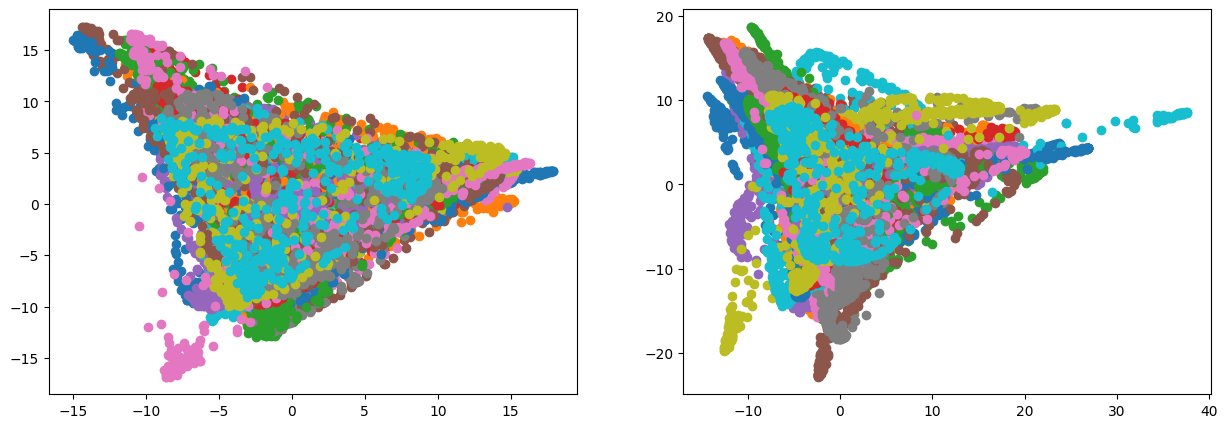

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for k in range(len(rest_aligned)):
    ax[0].scatter(super_aligned[k,:,0], super_aligned[k,:,1])
for k in range(len(rest_aligned)):
    ax[1].scatter(rest_aligned[k,:,0], rest_aligned[k,:,1])

In [9]:
# 1. compute correlation with the position
# 2. compute correlation with the distance to centroid
# 3. compute null distributions 

position_corr = {"pidx": [], "corr":[], "type": [], "gidx": []}
distance_corr = {"pidx": [], "corr":[], "type": []}

for gidx in range(3):
    for k in range(len(existing_psy)):
        feat = existing_psy[k]
        psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
        
        # 1. position_corr
        super_corr = [np.abs(pearson_correlation(super_aligned[:,i,gidx], psyscore))
                      for i in range(super_aligned.shape[1])]
        rest_corr = [np.abs(pearson_correlation(rest_aligned[:,i,gidx], psyscore))
                     for i in range(rest_aligned.shape[1])]
        
        # filling dataframe with info for super aligned
        position_corr["pidx"] += [feat] * len(super_corr)
        position_corr["corr"] += super_corr
        position_corr["type"] += ["movie"] * len(super_corr)
        position_corr["gidx"] += [gidx] * len(super_corr)
        # filling dataframe with info for rest alinged
        position_corr["pidx"] += [feat] * len(rest_corr)
        position_corr["corr"] += rest_corr
        position_corr["type"] += ["rest"] * len(rest_corr)
        position_corr["gidx"] += [gidx] * len(rest_corr)
        
        # 2. distance_corr
        if gidx == 0:
            D_super = np.asarray([D(super_aligned.mean(axis=1)[k],super_aligned[k]) for k in range(nsub)])
            D_rest = np.asarray([D(rest_aligned.mean(axis=1)[k],rest_aligned[k]) for k in range(nsub)])        
            super_corr = [np.abs(pearson_correlation(D_super[:,i], psyscore))
                          for i in range(super_aligned.shape[1])]
            rest_corr = [np.abs(pearson_correlation(D_rest[:,i], psyscore))
                         for i in range(rest_aligned.shape[1])]

            # filling dataframe with info for super aligned
            distance_corr["pidx"] += [feat] * len(super_corr)
            distance_corr["corr"] += super_corr
            distance_corr["type"] += ["movie"] * len(super_corr)
            # filling dataframe with info for rest alinged
            distance_corr["pidx"] += [feat] * len(rest_corr)
            distance_corr["corr"] += rest_corr
            distance_corr["type"] += ["rest"] * len(rest_corr)

pos_corr_df = pd.DataFrame.from_dict(position_corr)
dist_corr_df = pd.DataFrame.from_dict(distance_corr)

Look at null distribution per pidx and see what "chance level" is (Not ready)

In [10]:
null_iter = 100
super_null1 = {feat: [] for feat in existing_psy}
super_null2 = {feat: [] for feat in existing_psy}
rest_null1 = {feat: [] for feat in existing_psy}
rest_null2 = {feat: [] for feat in existing_psy}

for n in tqdm(range(null_iter)):
    
    for gidx in range(3):
        for k in range(len(existing_psy)):
            feat = existing_psy[k]
            psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() 
                        for i in range(len(subjects))]
            np.random.shuffle(psyscore)
            
            super_corr = [np.abs(pearson_correlation(super_aligned[:,i,gidx], psyscore))
                          for i in range(super_aligned.shape[1])]
            rest_corr = [np.abs(pearson_correlation(rest_aligned[:,i,gidx], psyscore))
                         for i in range(rest_aligned.shape[1])]

            super_null1[feat].append(super_corr)
            rest_null1[feat].append(rest_corr)

            if gidx == 0:
                D_super = np.asarray([D(super_aligned.mean(axis=1)[k],super_aligned[k]) for k in range(nsub)])
                D_rest = np.asarray([D(rest_aligned.mean(axis=1)[k],rest_aligned[k]) for k in range(nsub)])        
                super_corr = [np.abs(pearson_correlation(D_super[:,i], psyscore))
                              for i in range(super_aligned.shape[1])]
                rest_corr = [np.abs(pearson_correlation(D_rest[:,i], psyscore))
                             for i in range(rest_aligned.shape[1])]

                super_null2[feat].append(super_corr)
                rest_null2[feat].append(rest_corr)

  0%|          | 0/100 [00:00<?, ?it/s]

H0: r = 0 with current sample. p-value used for correlation follows this statistics (student t distributed):
$$ t= \frac{r\sqrt{n-2}}{\sqrt{1-r^2}}$$ 

in our case $n= 30$ and and we want two-tailed p-value to be at atmost 0.05. Our correlation then needs to be at least $r=$.

In [11]:
def t_stat(r,df):
    return r*np.sqrt(df)/np.sqrt(1-r**2)

In [12]:
p_std_corr = 0.362 # empirically quickly found
(1-stats.t.cdf(t_stat(p_std_corr,28), 28)) *2

0.04932711916387911

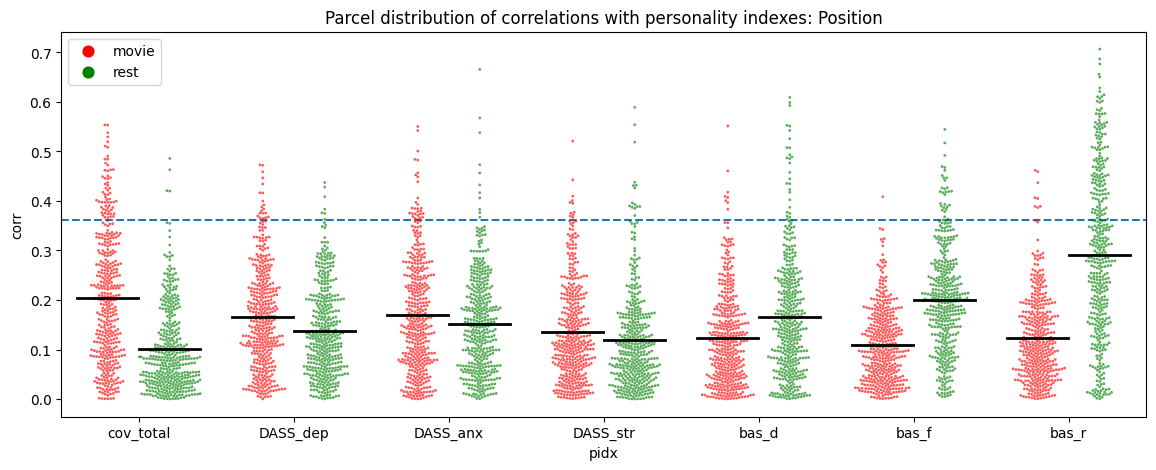

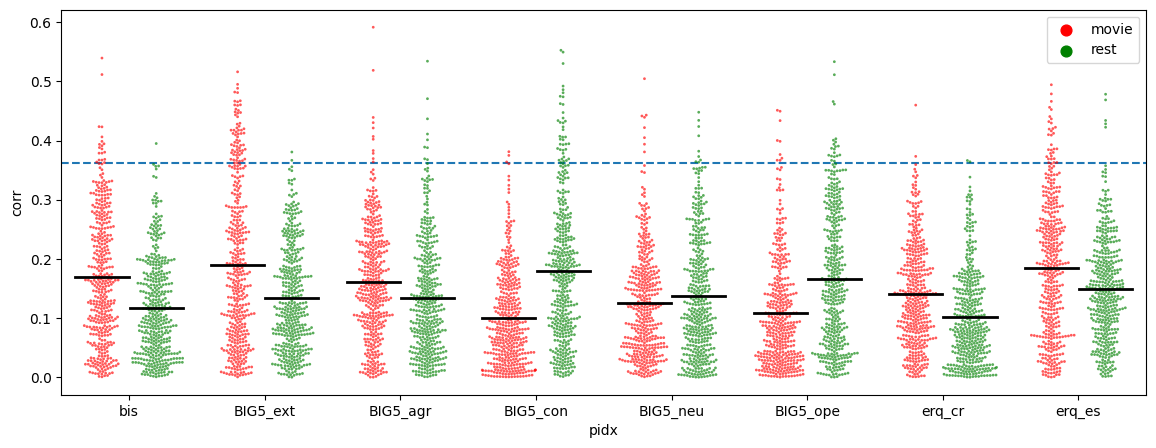

In [13]:
cur_df = pos_corr_df[pos_corr_df['gidx'] == 0]


# Plot 1
plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy1)], hue="type",
              color="r", alpha=.65, size=2, dodge=True, palette=sns.color_palette(['red', 'green']))
# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy1)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.title("Parcel distribution of correlations with personality indexes: Position")
plt.axhline(y=p_std_corr, linestyle='--', label='pval < 0.05 corr')
handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2], labels[:len(handles)//2])

plt.show()



# Plot 2
plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy2)], hue="type",
              color="r", alpha=.65, size=2, dodge=True, palette=sns.color_palette(['red', 'green']))

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy2)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
# plt.title("Distribution of prediction vs gt correlation on different folds")
plt.axhline(y=p_std_corr, linestyle='--', label='pval < 0.05 corr')
handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2], labels[:len(handles)//2])
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DASS_dep_movie vs. DASS_dep_rest: Custom statistical test, P_val:1.994e-06
cov_total_movie vs. cov_total_rest: Custom statistical test, P_val:1.487e-10
DASS_anx_movie vs. DASS_anx_rest: Custom statistical test, P_val:3.158e-01
DASS_str_movie vs. DASS_str_rest: Custom statistical test, P_val:3.945e-01
bas_d_movie vs. bas_d_rest: Custom statistical test, P_val:1.479e-02
bas_f_movie vs. bas_f_rest: Custom statistical test, P_val:1.630e-03
bas_r_movie vs. bas_r_rest: Custom statistical test, P_val:3.052e-23


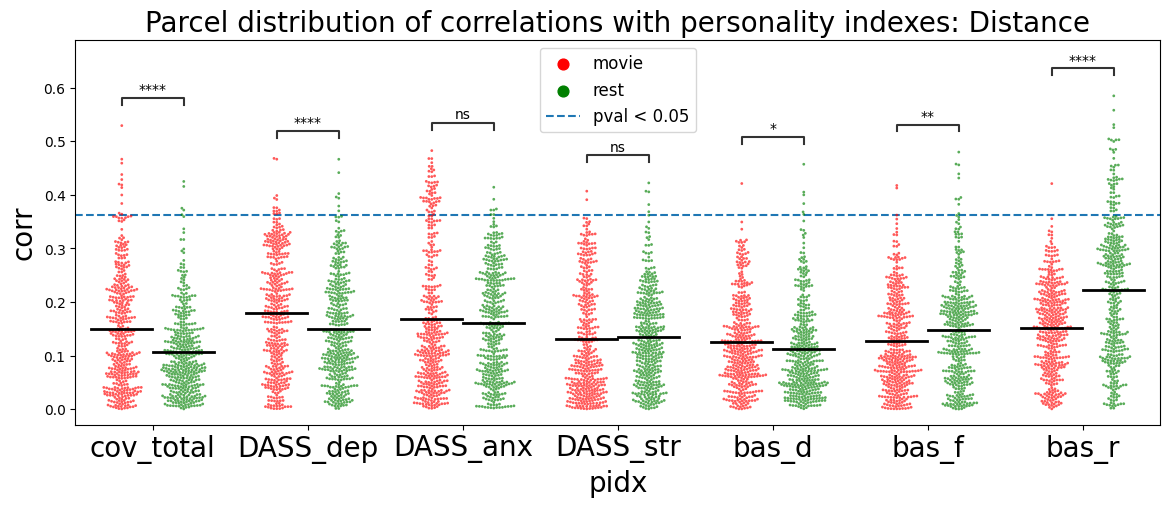

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BIG5_ext_movie vs. BIG5_ext_rest: Custom statistical test, P_val:2.088e-35
bis_movie vs. bis_rest: Custom statistical test, P_val:5.750e-02
BIG5_agr_movie vs. BIG5_agr_rest: Custom statistical test, P_val:8.459e-03
BIG5_con_movie vs. BIG5_con_rest: Custom statistical test, P_val:1.068e-30
BIG5_neu_movie vs. BIG5_neu_rest: Custom statistical test, P_val:6.626e-05
BIG5_ope_movie vs. BIG5_ope_rest: Custom statistical test, P_val:1.869e-15
erq_cr_movie vs. erq_cr_rest: Custom statistical test, P_val:6.248e-02
erq_es_movie vs. erq_es_rest: Custom statistical test, P_val:7.920e-12


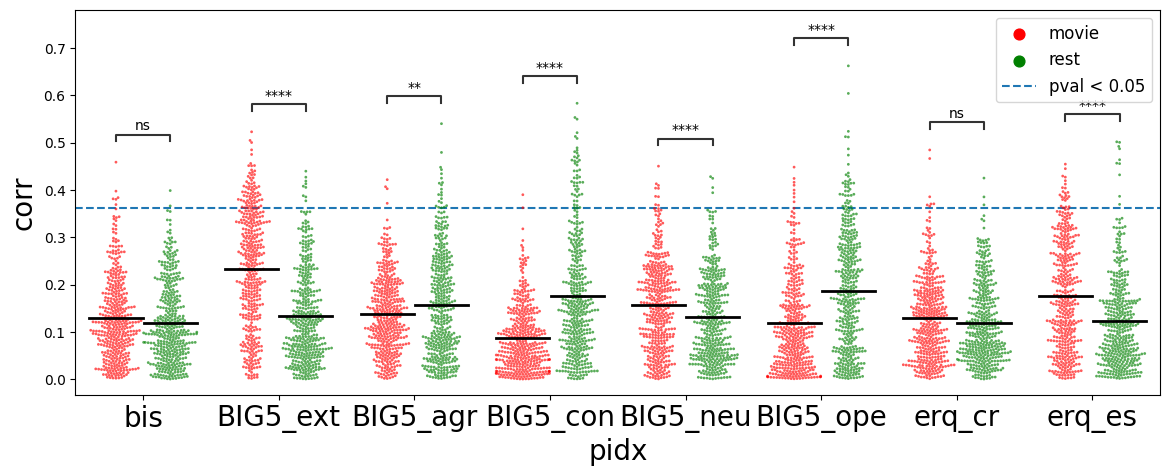

In [16]:
cur_df = dist_corr_df

# Plot 1
plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy1)], hue="type",
              color="r", alpha=.65, size=2, dodge=True, palette=sns.color_palette(['red', 'green']))
# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy1)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)

plotting_parameters = { 'data':    cur_df[cur_df['pidx'].isin(psy1)],'x':'pidx',
                       'y':'corr','hue':'type','palette': sns.color_palette(['black', 'red'])}

# paired t-test
pvalues = []
pairs = []
for psy_p in psy1:
    tmp = cur_df[cur_df['pidx'] == psy_p]
    arr1 = np.nan_to_num(list(tmp[tmp['type']=='movie']['corr']))
    arr2 = np.nan_to_num(list(tmp[tmp['type']=='rest']['corr']))
    pval = stats.ttest_rel(arr1, arr2).pvalue
    pvalues.append(pval)
    pairs.append(((psy_p,'movie'), (psy_p, 'rest')))

    
annotator = Annotator(p, pairs, **plotting_parameters)
annotator.set_pvalues(pvalues)
annotator.annotate()

p.set_ylabel('corr', fontsize=20)
p.set_xlabel('pidx', fontsize=20)
p.set_xticklabels(psy1, fontsize=20)

plt.title("Parcel distribution of correlations with personality indexes: Distance", fontsize=20)
plt.axhline(y=p_std_corr, linestyle='--', label='pval < 0.05')
handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2] + [handles[-1]], labels[:len(handles)//2] + [labels[-1]]
        ,prop={'size':12})
plt.show()




# Plot 2
plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy2)], hue="type",
              color="r", alpha=.65, size=2, dodge=True, palette=sns.color_palette(['red', 'green']))

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy2)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)

plotting_parameters = { 'data':    cur_df[cur_df['pidx'].isin(psy2)],'x':'pidx',
                       'y':'corr','hue':'type','palette': sns.color_palette(['black', 'red'])}

# paired t-test
pvalues = []
pairs = []
for psy_p in psy2:
    tmp = cur_df[cur_df['pidx'] == psy_p]
    arr1 = np.nan_to_num(list(tmp[tmp['type']=='movie']['corr']))
    arr2 = np.nan_to_num(list(tmp[tmp['type']=='rest']['corr']))
    pval = stats.ttest_rel(arr1, arr2).pvalue
    pvalues.append(pval)
    pairs.append(((psy_p,'movie'), (psy_p, 'rest')))

annotator = Annotator(p, pairs, **plotting_parameters)
annotator.set_pvalues(pvalues)
annotator.annotate()

p.set_ylabel('corr', fontsize=20)
p.set_xlabel('pidx', fontsize=20)
p.set_xticklabels(psy2, fontsize=20)

plt.axhline(y=p_std_corr, linestyle='--', label='pval < 0.05')
handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2] + [handles[-1]], labels[:len(handles)//2] + [labels[-1]],
        prop={'size':12})
# plt.title("Distribution of prediction vs gt correlation on different folds")
plt.show()

<a class="anchor" id="correval_fselect"></a>
## Correlation evaluation on Frame selected

#### Visual difference

In [17]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
nb_comp    = 3
rs         = 99

In [19]:
total_series = load('./data/fmri_414_series.pkl')
f_series = load('./resources/threshed_series/fa_treshed_series.pkl')

if 'Rest' in total_series: del total_series['Rest']
if 'Rest' in f_series: del f_series['Rest']

In [20]:
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

thresh_all = s5+s10+s20+s25+s33+s50

Script to generate per id 3FA selected gradients (untoggle)

In [7]:
# fa_fselect_gradients = {}
# for k in tqdm(range(3)):
#     all_fselect_gradients = {}
#     for bound in tqdm(s5+s10+s20+s25+s33+s50):
#         fselected_series = f_series[k][bound]
#         fselect_subjects = {_id:[] for _id in fselected_series['Sintel'].keys()}
#         # array swap
#         for mname in fselected_series:
#             tmp_dict = fselected_series[mname]

#             for _id in tmp_dict:
#                 tmp_series = tmp_dict[_id]
#                 fselect_subjects[_id].append(tmp_series)

#         # fselect gradients compute
#         fselect_gradients = {}
#         for _id in fselect_subjects:
#             tmp_series = np.concatenate(fselect_subjects[_id])
#             fc_select = FC(tmp_series)
#             g_select = GradientMaps(n_components=nb_comp, approach=embedding, 
#                                     kernel=aff_kernel, random_state=rs)
#             g_select.fit(fc_select)
#             grad = g_select.gradients_

#             # fscore = D(grad.mean(axis=0), grad)
#             fselect_gradients[_id] = grad

#         all_fselect_gradients[bound] = fselect_gradients

#     fa_fselect_gradients[k] = all_fselect_gradients

# save("./resources/fselect_grads/fa_scores_withID/fselected_grads_supermovie_withID.pkl", fa_fselect_gradients)

hide()

Script to generate per id random gradients (untoggle)

In [11]:
# np.random.seed(99)

# nb_iter = 200
# for ssize in tqdm([5,10,20,25,33,50]):
#     null_gradients = []

#     for _ in tqdm(range(nb_iter)):
#         frandom_subjects = {_id:[] for _id in total_series['Sintel'].keys()}
#         # array swap
#         for mname in total_series:
#             tmp_dict = total_series[mname]
#             tmp = tmp_dict[next(iter(tmp_dict))]
#             perc_left = tmp.shape[0]*ssize//100
#             sample_idx = np.random.choice(np.arange(tmp.shape[0]),perc_left, replace=False)

#             for _id in tmp_dict:
#                 tmp_series = tmp_dict[_id][sample_idx]
#                 frandom_subjects[_id].append(tmp_series)

#         # all movies gradients compute
#         frandom_gradients = {}
#         for _id in frandom_subjects:
#             tmp_series = np.concatenate(frandom_subjects[_id])
#             fc_random = FC(tmp_series)
#             g_random = GradientMaps(n_components=nb_comp, approach=embedding, 
#                                     kernel=aff_kernel, random_state=rs)
#             g_random.fit(fc_random)
#             grad = g_random.gradients_
#             frandom_gradients[_id] = grad
#         null_gradients.append(frandom_gradients)
#     save("./resources/null_grad/sample_fselect_withID/nullsample_{}.pkl".format(ssize), null_gradients)

hide()

Load the related gradients and compute their properties

In [21]:
fa_fselect_gradients = load('./resources/fselect_grads/fa_scores_withID/fselected_grads_supermovie_withID.pkl')

In [22]:
fa_fselect_dist = {}
for fa_nb in range(3):
    fa_tmp = fa_fselect_gradients[fa_nb]
    per_fa = {}
    for bound in s5+s10+s20+s25+s33+s50:
        per_bound = {}
        tmp_grads = fa_tmp[bound]
        for _id in tmp_grads:
            dist = D(tmp_grads[_id].mean(axis=0),tmp_grads[_id])
            per_bound[_id] = dist

        per_fa[bound] = per_bound
    fa_fselect_dist[fa_nb] = per_fa

In [23]:
null_dist = {}
for ssize in [5,10,20,25,33,50]:
    tmp = load("./resources/null_grad/sample_fselect_withID/nullsample_{}.pkl".format(ssize))
    dists = []
    for n_iter in range(len(tmp)):
        per_iter = {}
        tmp_grads = tmp[n_iter]
        for _id in tmp_grads:
            dist = D(tmp_grads[_id].mean(axis=0),tmp_grads[_id])
            per_iter[_id] = dist
        dists.append(per_iter)
    null_dist[ssize] = dists

### Correlation Computation Full Gradients

In [24]:
# we use Valence for now
all_fselect_gradients = deepcopy(fa_fselect_dist[2])
subjects = list(all_fselect_gradients[(0,5)].keys())

#### Across different bounds of frame selection

In [33]:
B = deepcopy(s33)
all_array = np.asarray([[all_fselect_gradients[s][sub] for sub in subjects] for s in B])

In [34]:
pred_distrib_selects = {'pidx': [], 'foldcorr': [], 'type': []}

for k in range(len(existing_psy)):
    feat = existing_psy[k]
    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    all_corr = [[pearson_correlation(all_array[k,:,i], psyscore) for i in range(414)] 
                for k in range(len(all_array))]
    
    for k in range(len(all_corr)):
        pred_distrib_selects['foldcorr'] += list(np.abs(all_corr[k]))
        pred_distrib_selects['pidx'] += len(all_corr[k]) * [feat]
        pred_distrib_selects['type'] += len(all_corr[k]) * [B[k]]

pred_selects_df = pd.DataFrame.from_dict(pred_distrib_selects)

# combine with baseline of movies and rest
tmp_df = deepcopy(dist_corr_df)
pred_selects_df = pd.concat([pred_selects_df, tmp_df.rename(columns={"corr": "foldcorr"})])

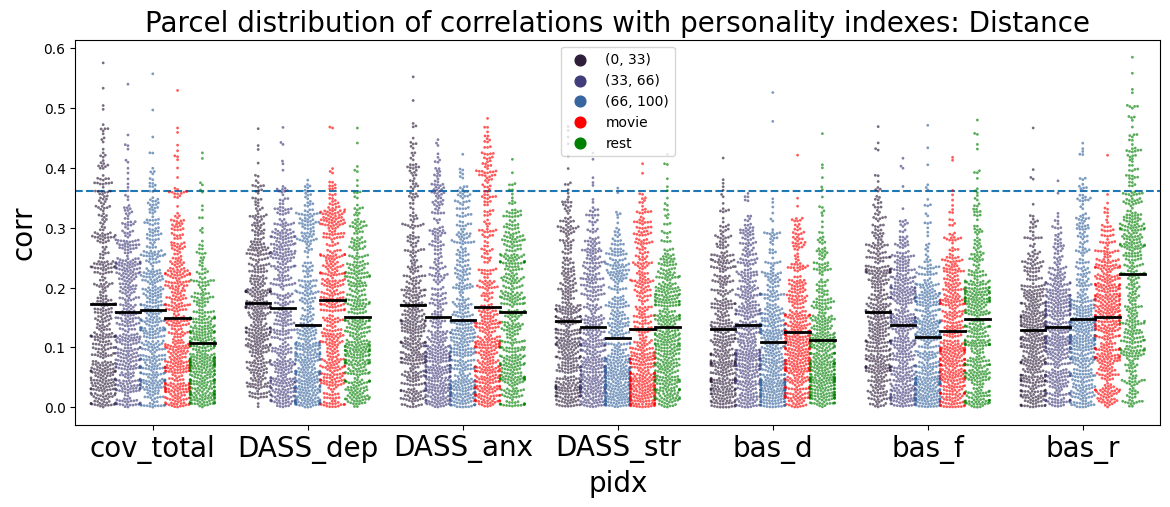

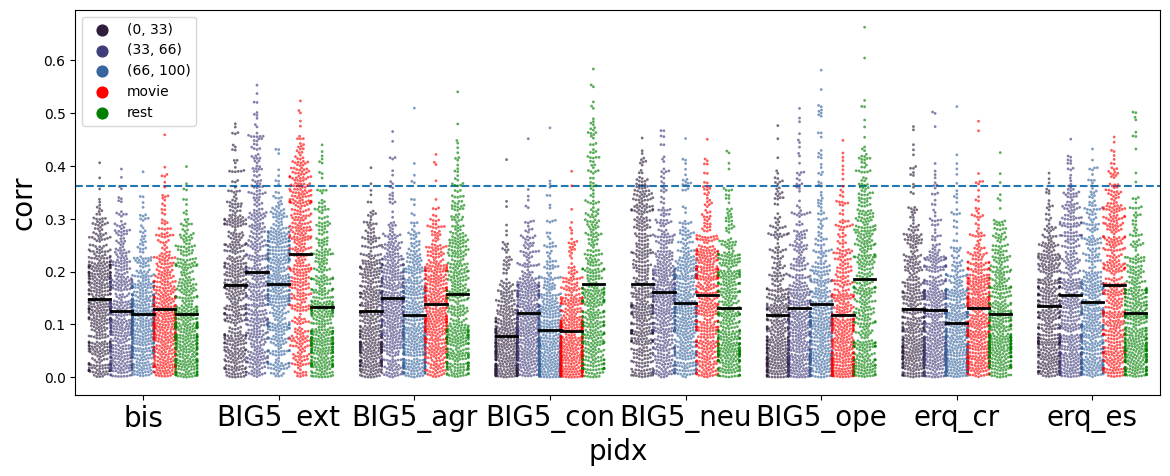

In [37]:
plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="foldcorr", data=pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[:len(existing_psy)//2])], hue="type",
              color="r", alpha=.65, size=2, dodge=True,
                  palette=list(sns.color_palette("mako", as_cmap=False)[:3]+['r','g']))

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="foldcorr", hue="type",
            data=pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[:len(existing_psy)//2])],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)

p.set_ylabel('corr', fontsize=20)
p.set_xlabel('pidx', fontsize=20)
p.set_xticklabels(psy1, fontsize=20)

plt.title("Parcel distribution of correlations with personality indexes: Distance", fontsize=20)
handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2], labels[:len(handles)//2])
plt.axhline(y=p_std_corr, linestyle='--', label='pval < 0.05 corr')
plt.show()


plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="foldcorr", data=pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[len(existing_psy)//2:])], hue="type",
              color="r", alpha=.65, size=2, dodge=True,
                  palette=list(sns.color_palette("mako", as_cmap=False)[:3]+['r','g']))

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="foldcorr", hue="type",
            data=pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[len(existing_psy)//2:])],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)

p.set_ylabel('corr', fontsize=20)
p.set_xlabel('pidx', fontsize=20)
p.set_xticklabels(psy2, fontsize=20)

handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2], labels[:len(handles)//2])
plt.axhline(y=p_std_corr, linestyle='--', label='pval < 0.05 corr')
plt.show()

### Visualize correlation on cortical displays


In [81]:
pidx = 'DASS_dep'
eg_df = pred_selects_df[pred_selects_df['pidx'] == pidx]
gs = []
for _type in eg_df.type.unique():
    gs.append(list(eg_df[eg_df['type'] == _type]['foldcorr']))
gs = np.asarray(gs)

In [ ]:
# Parcellation 400
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0

bounds = [(np.concatenate(gs).min(), np.concatenate(gs).max())]
grad = [None] * 6
for i in range(6):
    # map the gradient to the parcels
    grad[i] = map_to_labels(gs[i][:400], labeling, mask=mask, fill=np.nan)

text_labels = ['grad: {}'.format(un) for un in eg_df.type.unique()]
paths = ['../figures/corr_{}.jpg'.format(k) for k in range(6)]
for k in range(6):
    genpath = paths[k]
    plot_hemispheres(surf_lh, surf_rh, array_name=[grad[k]], size=(550, 450), cmap='viridis_r', layout_style="grid",
        color_bar=True, label_text=[text_labels[k]], zoom=.9, embed_nb=True, interactive=False, screenshot=True, filename=genpath,
        transparent_bg=False, color_range=bounds[0])

### Network level (we show yeo 17)

In [38]:
B = deepcopy(s33)
all_array = np.asarray([[all_fselect_gradients[s][sub] for sub in subjects] for s in B])
# B += ['Movie','Rest']
# merge with baseline for movie and rest (in this order)
# all_array = np.concatenate([all_array,D_super[None],D_rest[None]])

In [39]:
pred_distrib_selects = {'pidx': [], 'foldcorr': [], 'type': [], 'net': []}

for psy_nb in range(len(existing_psy)):
    feat = existing_psy[psy_nb]
    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    
    for net in index2region17:
        
        all_corr = [[pearson_correlation(all_array[k,:,i], psyscore) for i in index2region17[net]] 
                    for k in range(len(all_array))]

        for s in range(len(all_corr)):
            pred_distrib_selects['foldcorr'] += list(np.abs(all_corr[s]))
            pred_distrib_selects['pidx'] += len(all_corr[s]) * [feat]
            pred_distrib_selects['type'] += len(all_corr[s]) * [B[s]]
            pred_distrib_selects['net'] += len(all_corr[s]) * [net]

pred_selects_df = pd.DataFrame.from_dict(pred_distrib_selects)

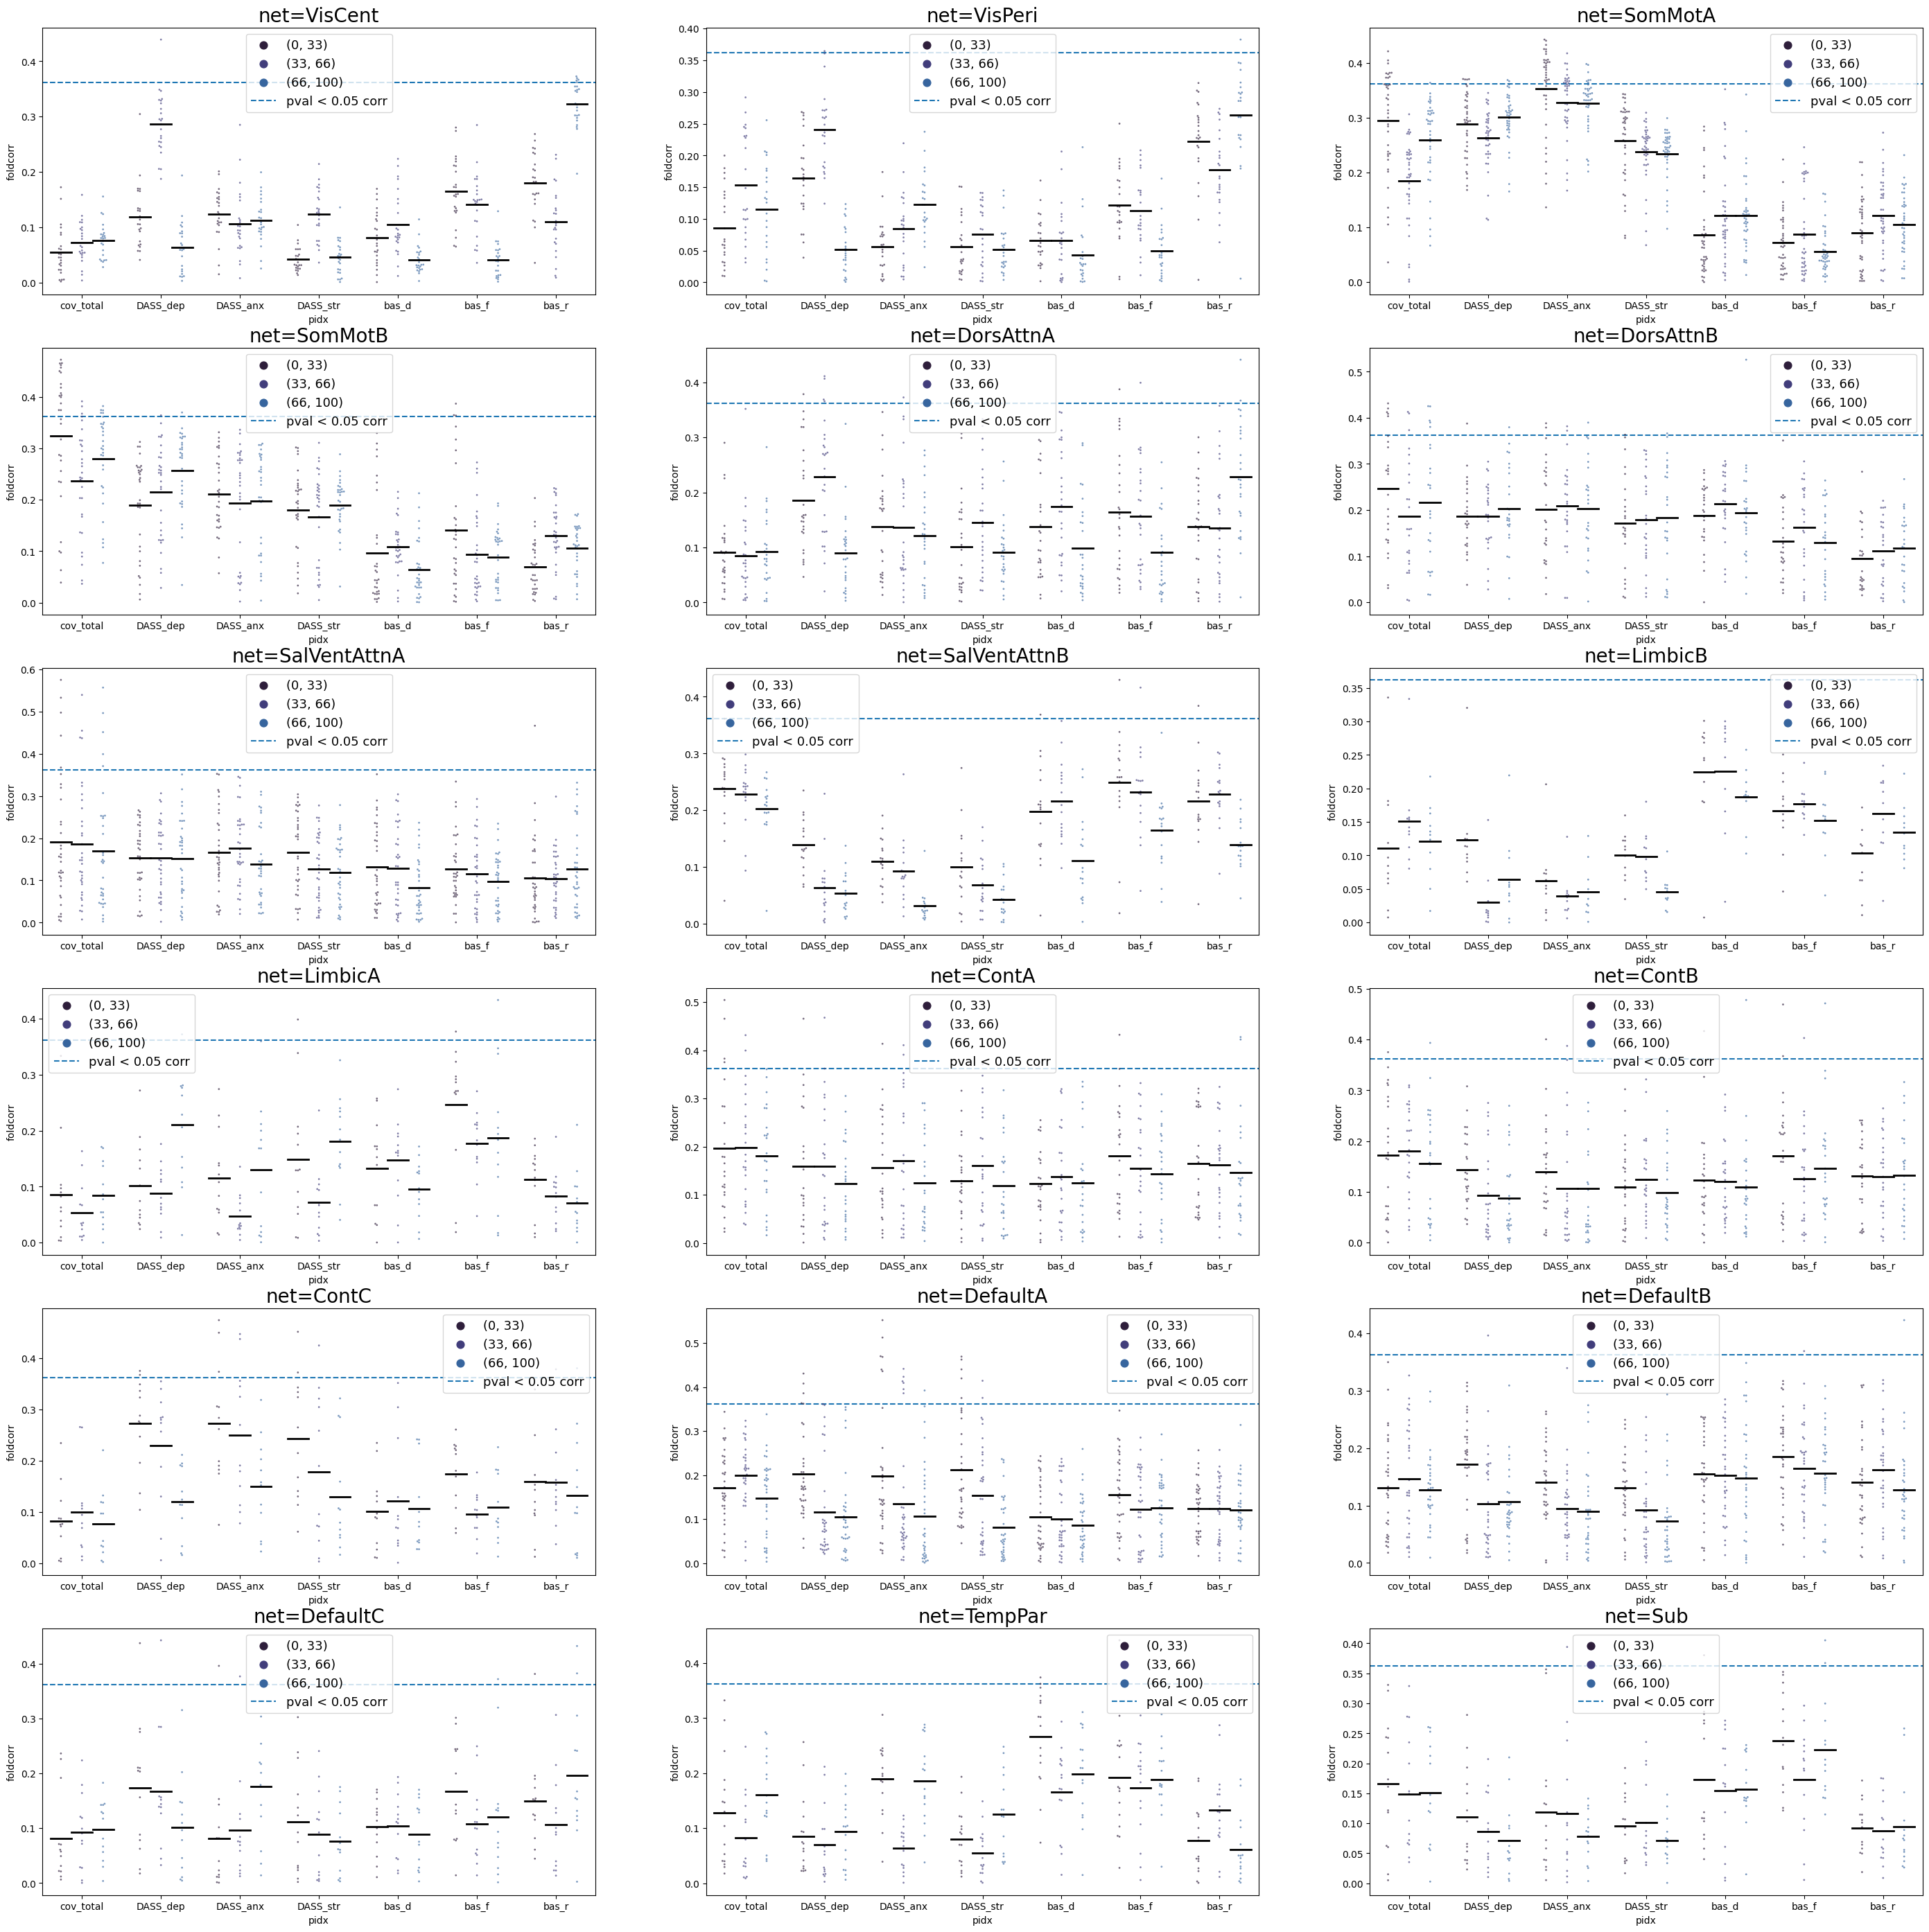

In [46]:
fig, ax = plt.subplots(6,3, figsize=(35,35))
cur_df = pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[:len(existing_psy)//2])]

for idx,net in enumerate(index2region17):
    r,c = idx//3,idx%3
    p = sns.swarmplot(x="pidx", y="foldcorr", data=cur_df[cur_df['net']==net], hue="type",
                  color="r", alpha=.65, size=2, dodge=True, ax=ax[r,c],
                palette=list(sns.color_palette("mako", as_cmap=False)[:3]+['r','g']))
    ax[r,c].axhline(y=p_std_corr, linestyle='--', label='pval < 0.05 corr')
    # plot the mean line
    sns.boxplot(showmeans=True,
                meanline=True,
                meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                medianprops={'visible': False},
                whiskerprops={'visible': False},
                zorder=10,
                x="pidx",
                y="foldcorr", hue="type",
                data=cur_df[cur_df['net']==net],
                showfliers=False,
                showbox=False,
                showcaps=False,
                ax=p)

    handles, labels = p.get_legend_handles_labels()
    p.legend(handles[:len(handles)//2+1], labels[:len(handles)//2+1], prop={'size':13})

    ax[r,c].set_title('net={}'.format(net), fontsize=20)
    
plt.show()

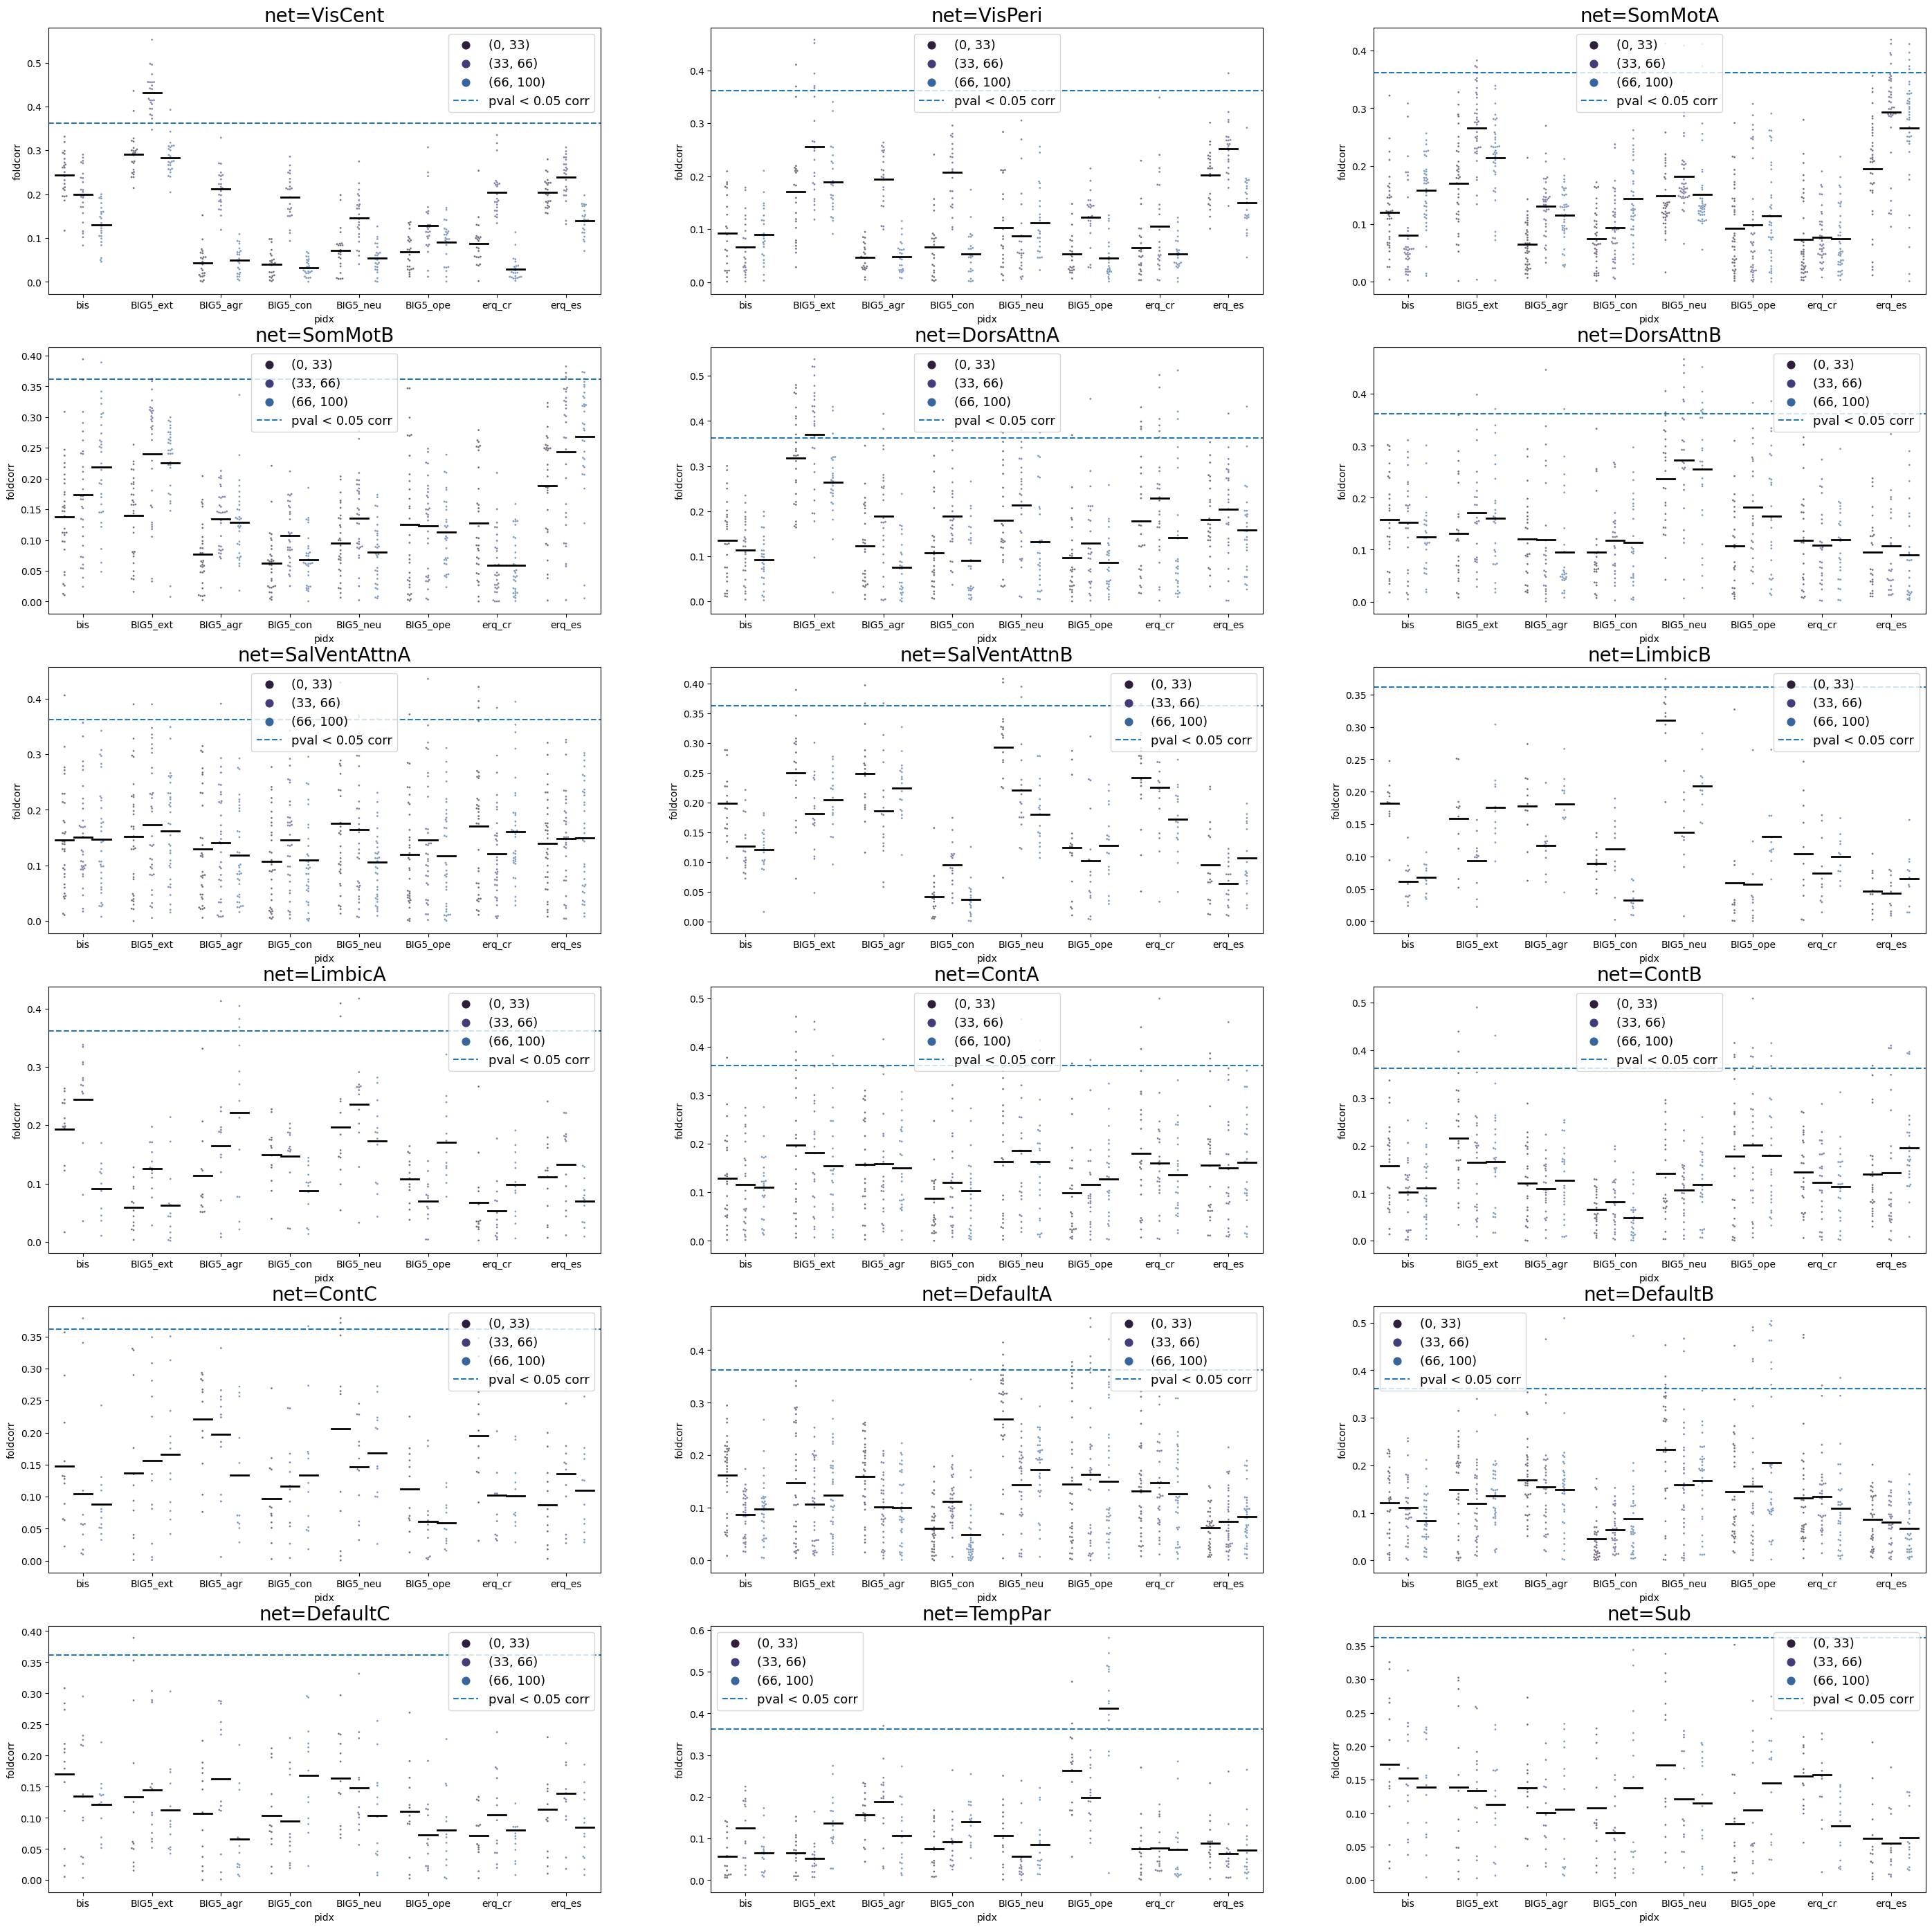

In [47]:
fig, ax = plt.subplots(6,3, figsize=(35,35))
cur_df = pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[len(existing_psy)//2:])]

for idx,net in enumerate(index2region17):
    r,c = idx//3,idx%3
    p = sns.swarmplot(x="pidx", y="foldcorr", data=cur_df[cur_df['net']==net], hue="type",
                  color="r", alpha=.65, size=2, dodge=True, ax=ax[r,c],
                palette=list(sns.color_palette("mako", as_cmap=False)[:3]+['r','g']))
    ax[r,c].axhline(y=p_std_corr, linestyle='--', label='pval < 0.05 corr')
    # plot the mean line
    sns.boxplot(showmeans=True,
                meanline=True,
                meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                medianprops={'visible': False},
                whiskerprops={'visible': False},
                zorder=10,
                x="pidx",
                y="foldcorr", hue="type",
                data=cur_df[cur_df['net']==net],
                showfliers=False,
                showbox=False,
                showcaps=False,
                ax=p)

    handles, labels = p.get_legend_handles_labels()
    p.legend(handles[:len(handles)//2+1], labels[:len(handles)//2+1], prop={'size':13})
    

    ax[r,c].set_title('net={}'.format(net), fontsize=20)
    
plt.show()